In [6]:
# ================== Reddit Marketing Pipeline (Netflix vs Prime) ==================
# Scrape r/netflix, r/primevideo (+ r/cordcutters), filter marketing talk, label themes,
# run sentiment (VADER), and produce comparison visuals (counts, heatmaps, trends, sentiment).

!pip install praw pandas numpy nltk scikit-learn matplotlib seaborn wordcloud

import os, time, re, json, urllib.request, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & ML
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

# Optional extras
try:
    from wordcloud import WordCloud
    WORDCLOUD_OK = True
except Exception:
    WORDCLOUD_OK = False

# Reddit API
try:
    import praw
    PRAW_OK = True
except Exception:
    PRAW_OK = False

# ---------------- CONFIG ----------------
BASE = "/Users/saurabkohad/Downloads"   # <- change if needed
OUT_DIR = os.path.join(BASE, "reddit_marketing_outputs")
os.makedirs(OUT_DIR, exist_ok=True)

SUBREDDITS = ["netflix", "primevideo", "cordcutters"]  # add/remove as you like
DAYS_BACK = 365                                        # time window
LIMIT_PER_SUB = 1500                                   # submissions cap per subreddit

CONFIG = {
    "client_id":     "WlwokjHm54GvT2zzmOSNGQ",
    "client_secret": "VgJ2XCrqqig-RREEcmbkyWRqWzLBZw",
    "user_agent":    "dissertation_research by u/saurabkohad"
}

# Marketing theme lexicon (lowercase regex)
THEME_LEXICON = {
    "pricing":        r"(price|pricing|hike|increase|cost|expensive|cheap|discount|student|trial|free trial|annual|monthly|bundle price)",
    "offers":         r"(offer|promo|promotion|deal|coupon|voucher|cashback|sale)",
    "notifications":  r"(notification|push|email|reminder|nudge|alert|pop[- ]?up)",
    "recommendations":r"(recommend|recommended|algorithm|algo|personaliz|suggestion|because you watched|autoplay|continue watching)",
    "content":        r"(originals?|exclusive|catalogue|catalog|library|new release|show|movie|series|season|sports)",
    "bundle":         r"(bundle|prime (benefits|shipping)|amazon|music|twitch|one[- ]?day|delivery|kindle)",
    "service_quality":r"(ui|ux|interface|app|buffer|lag|4k|hdr|ads?|ad[- ]?supported|login|account|payment)",
    "churn_switch":   r"(cancel|churn|quit|left|unsubscribe|switch|switched|moved to|drop(ped)?)"
}
THEME_REGEX = {k: re.compile(v, re.IGNORECASE) for k, v in THEME_LEXICON.items()}

# Keyword filter = gate to mark posts/comments as “marketing-relevant”
FILTER_KEYWORDS = re.compile(
    r"(recommend|algorithm|notification|email|offer|discount|price|pricing|trial|free trial|bundle|"
    r"promotion|promo|cancel|churn|unsubscribe|switch|ui|ux|autoplay|continue watching|originals?|exclusive|ads?)",
    re.IGNORECASE
)

# ---------------- Utilities ----------------
def clean_text(s):
    return re.sub(r"\s+", " ", str(s or "")).strip()

def detect_themes(text):
    if not text: 
        return ["other"]
    found = []
    for theme, rx in THEME_REGEX.items():
        if rx.search(text):
            found.append(theme)
    return found if found else ["other"]

def to_date(epoch):
    return dt.datetime.utcfromtimestamp(epoch).date()

def sentiment_scores(text, sia):
    if not text:
        return dict(neg=np.nan, neu=np.nan, pos=np.nan, compound=np.nan)
    return sia.polarity_scores(text)

# ---------------- Scraping ----------------
def praw_client(cfg):
    return praw.Reddit(client_id=cfg["client_id"],
                       client_secret=cfg["client_secret"],
                       user_agent=cfg["user_agent"])

def scrape_praw_subreddit(reddit, sub, since_utc, limit=1500):
    rows = []
    count = 0
    for submission in reddit.subreddit(sub).new(limit=None):
        if submission.created_utc < since_utc:
            break
        count += 1
        rows.append({
            "platform": "Netflix" if sub == "netflix" else "Prime" if sub == "primevideo" else "Mixed",
            "subreddit": sub,
            "type": "post",
            "id": submission.id,
            "created_utc": submission.created_utc,
            "created_date": to_date(submission.created_utc),
            "score": submission.score,
            "num_comments": submission.num_comments,
            "title": clean_text(getattr(submission, "title", "")),
            "body": clean_text(getattr(submission, "selftext", "")),
            "permalink": f"https://reddit.com{submission.permalink}"
        })
        # comments
        submission.comments.replace_more(limit=0)
        for c in submission.comments.list():
            rows.append({
                "platform": "Netflix" if sub == "netflix" else "Prime" if sub == "primevideo" else "Mixed",
                "subreddit": sub,
                "type": "comment",
                "id": f"{submission.id}_{getattr(c, 'id', 'na')}",
                "created_utc": getattr(c, "created_utc", submission.created_utc),
                "created_date": to_date(getattr(c, "created_utc", submission.created_utc)),
                "score": getattr(c, "score", np.nan),
                "num_comments": np.nan,
                "title": clean_text(getattr(submission, "title", "")),
                "body": clean_text(getattr(c, "body", "")),
                "permalink": f"https://reddit.com{submission.permalink}"
            })
        if count >= limit:
            break
    return pd.DataFrame(rows)

def pushshift_submissions(sub, since_utc, size=1000):
    url = (
        "https://api.pushshift.io/reddit/search/submission/"
        f"?subreddit={sub}&size={size}&sort=desc&sort_type=created_utc&after={int(since_utc)}"
    )
    with urllib.request.urlopen(url) as resp:
        data = json.loads(resp.read().decode("utf-8"))
    rows = []
    for d in data.get("data", []):
        rows.append({
            "platform": "Netflix" if sub == "netflix" else "Prime" if sub == "primevideo" else "Mixed",
            "subreddit": sub,
            "type": "post",
            "id": d.get("id"),
            "created_utc": d.get("created_utc"),
            "created_date": to_date(d.get("created_utc")),
            "score": d.get("score", np.nan),
            "num_comments": d.get("num_comments", np.nan),
            "title": clean_text(d.get("title")),
            "body": clean_text(d.get("selftext")),
            "permalink": d.get("permalink", "")
        })
    return pd.DataFrame(rows)

# ================= RUN SCRAPE =================
since_date = dt.date.today() - dt.timedelta(days=DAYS_BACK)
since_utc = int(dt.datetime.combine(since_date, dt.time.min).timestamp())

dfs = []
if PRAW_OK and all(CONFIG.values()):
    reddit = praw_client(CONFIG)
    for sub in SUBREDDITS:
        print(f"Scraping r/{sub} via PRAW …")
        df_sub = scrape_praw_subreddit(reddit, sub, since_utc, limit=LIMIT_PER_SUB)
        dfs.append(df_sub)
        time.sleep(2)
else:
    print("PRAW not available or credentials missing; using Pushshift (posts only).")
    for sub in SUBREDDITS:
        print(f"Scraping r/{sub} via Pushshift …")
        df_sub = pushshift_submissions(sub, since_utc, size=LIMIT_PER_SUB)
        dfs.append(df_sub)
        time.sleep(1)

raw = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
raw = raw.dropna(subset=["title", "body"], how="all")
raw["text"] = (raw["title"].fillna("") + " " + raw["body"].fillna("")).str.strip()
raw["text_len"] = raw["text"].str.len()
raw = raw[raw["text_len"] > 0].copy()

raw_path = os.path.join(OUT_DIR, "reddit_raw.csv")
raw.to_csv(raw_path, index=False)
print(f"Saved raw scrape → {raw_path}   rows={len(raw)}")

# ================= FILTER → THEMES → SENTIMENT =================
# Only marketing-relevant rows
mrk = raw[ raw["text"].str.contains(FILTER_KEYWORDS, na=False) ].copy()
print("Marketing‑relevant rows:", len(mrk))

# Theme detection (multi-label then explode)
mrk["themes"] = mrk["text"].apply(detect_themes)
mrk = mrk.explode("themes").rename(columns={"themes":"theme"})

# VADER
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()
sent = mrk["text"].apply(lambda t: sentiment_scores(t, sia)).apply(pd.Series)
mrk = pd.concat([mrk, sent], axis=1)

# Normalize platform if "Mixed" via keyword hits
def infer_platform(row):
    if row["platform"] in ["Netflix", "Prime"]:
        return row["platform"]
    t = str(row["text"]).lower()
    if "netflix" in t:
        return "Netflix"
    if "prime video" in t or "primevideo" in t or "on prime" in t or "amazon" in t:
        return "Prime"
    return "Mixed"

mrk["platform_norm"] = mrk.apply(infer_platform, axis=1)

clean_path = os.path.join(OUT_DIR, "reddit_marketing_clean.csv")
mrk.to_csv(clean_path, index=False)
print(f"Saved marketing‑clean → {clean_path}   rows={len(mrk)}")

# ================== VISUALS ==================
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 140

def savefig(name):
    plt.tight_layout()
    path = os.path.join(OUT_DIR, name)
    plt.savefig(path, bbox_inches="tight")
    plt.show()
    print("Saved:", path)

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Scraping r/netflix via PRAW …
Scraping r/primevideo via PRAW …
Scraping r/cordcutters via PRAW …
Saved raw scrape → /Users/saurabkohad/Downloads/reddit_marketing_outputs/reddit_raw.csv   rows=49395


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:190: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mrk = raw[ raw["text"].str.contains(FILTER_KEYWORDS, na=False) ].copy()


Marketing‑relevant rows: 27325
Saved marketing‑clean → /Users/saurabkohad/Downloads/reddit_marketing_outputs/reddit_marketing_clean.csv   rows=49529


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:225: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:227: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


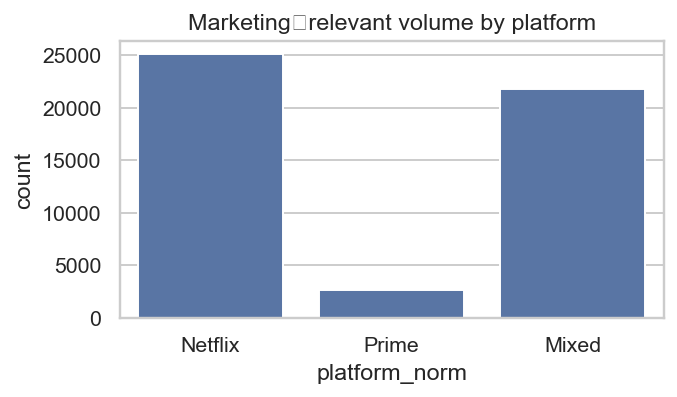

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/01_volume_by_platform.png


In [7]:
# 1) Volume by platform
plt.figure(figsize=(5,3))
sns.countplot(data=mrk, x="platform_norm", order=["Netflix","Prime","Mixed"])
plt.title("Marketing‑relevant volume by platform")
savefig("01_volume_by_platform.png")

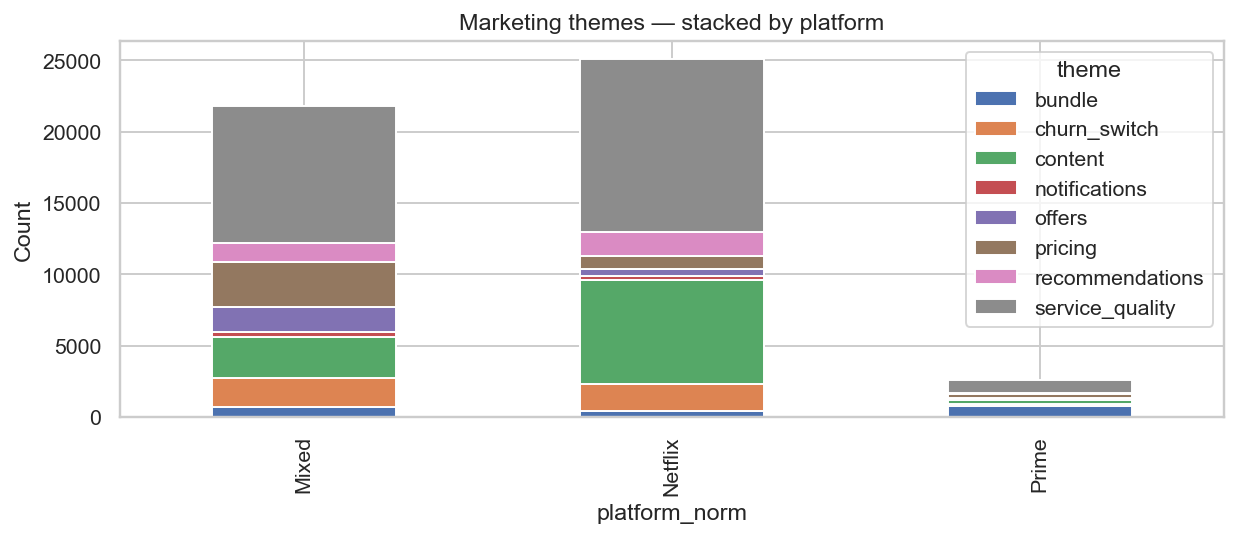

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/02_themes_stacked_by_platform.png


In [8]:
# 2) Theme distribution per platform (stacked)
theme_counts = (mrk.groupby(["platform_norm","theme"]).size()
                .reset_index(name="count"))
pivot_theme = theme_counts.pivot(index="platform_norm", columns="theme", values="count").fillna(0)
pivot_theme[sorted(pivot_theme.columns)] \
    .plot(kind="bar", stacked=True, figsize=(9,4))
plt.title("Marketing themes — stacked by platform")
plt.ylabel("Count")
savefig("02_themes_stacked_by_platform.png")

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:225: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:227: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


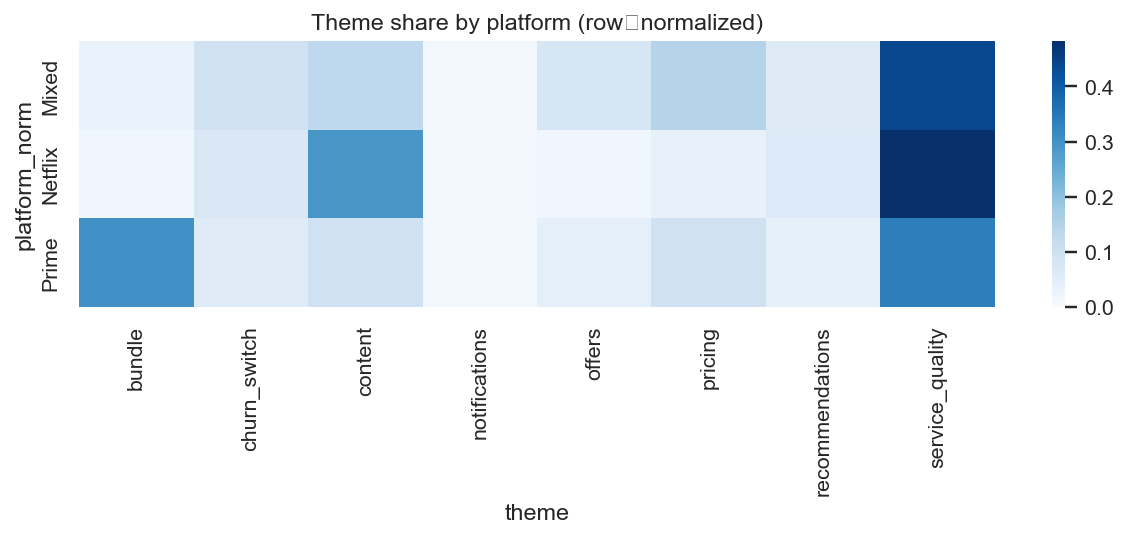

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/03_theme_heatmap_row_norm.png


In [9]:
# 3) Theme heatmap (normalized by row)
row_norm = pivot_theme.div(pivot_theme.sum(axis=1), axis=0)
plt.figure(figsize=(9,4))
sns.heatmap(row_norm[sorted(row_norm.columns)], cmap="Blues", vmin=0, vmax=row_norm.values.max())
plt.title("Theme share by platform (row‑normalized)")
savefig("03_theme_heatmap_row_norm.png")

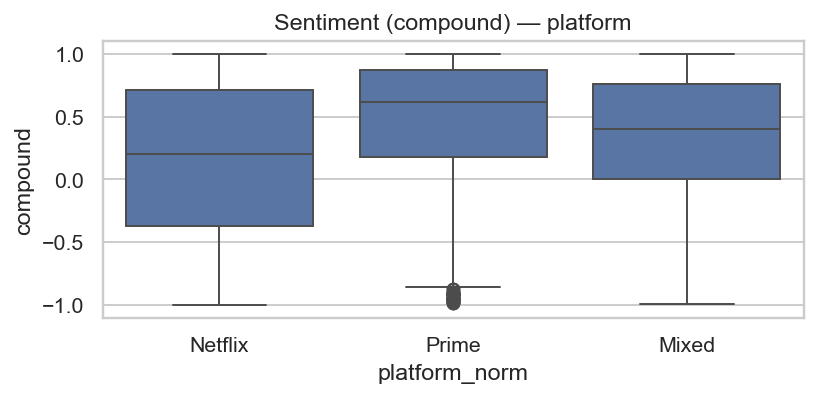

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/04_sentiment_platform_box.png


In [10]:
# 4) Sentiment by platform (box)
plt.figure(figsize=(6,3))
sns.boxplot(data=mrk, x="platform_norm", y="compound", order=["Netflix","Prime","Mixed"])
plt.title("Sentiment (compound) — platform")
savefig("04_sentiment_platform_box.png")

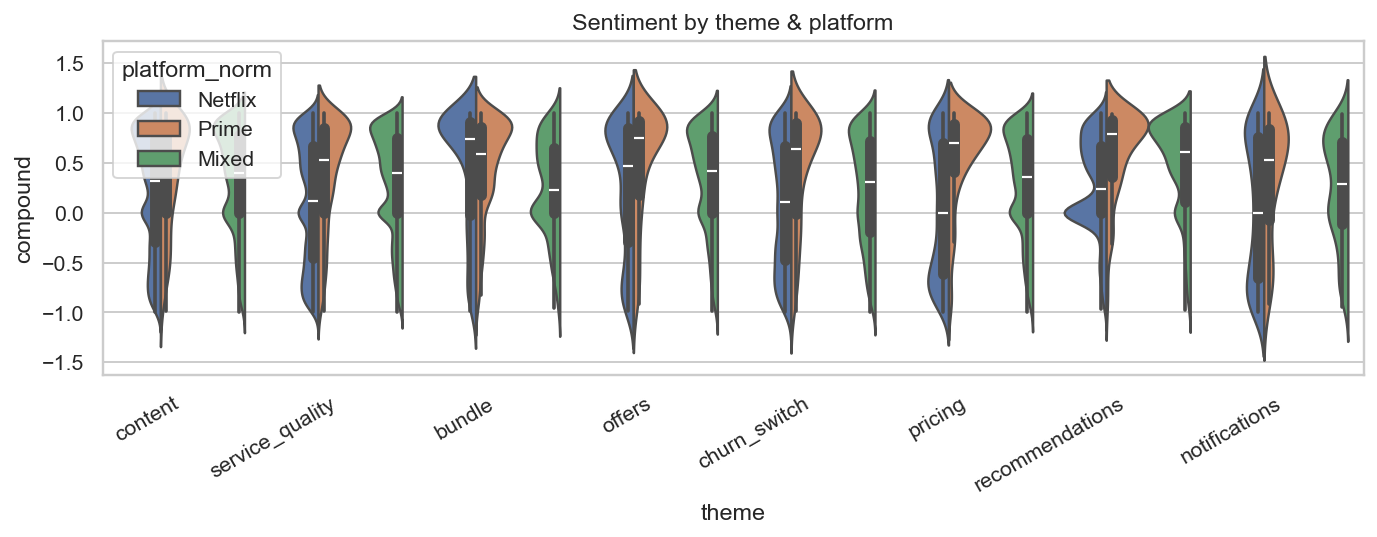

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/05_sentiment_theme_platform_violin.png


In [11]:
# 5) Sentiment by theme & platform (violin)
plt.figure(figsize=(10,4))
sns.violinplot(data=mrk, x="theme", y="compound", hue="platform_norm", split=True)
plt.xticks(rotation=30, ha="right")
plt.title("Sentiment by theme & platform")
savefig("05_sentiment_theme_platform_violin.png")

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:225: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:227: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


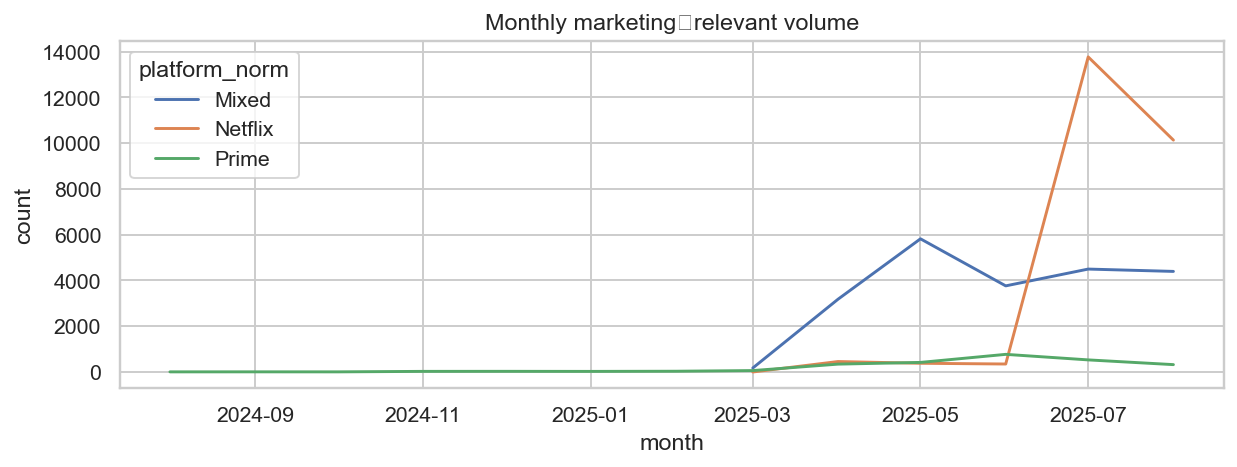

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/06_trend_monthly_volume.png


In [12]:
# 6) Monthly trends (volume)
mrk["month"] = pd.to_datetime(mrk["created_date"]).dt.to_period("M").dt.to_timestamp()
monthly = mrk.groupby(["platform_norm","month"]).size().reset_index(name="count")
plt.figure(figsize=(9,3.5))
sns.lineplot(data=monthly, x="month", y="count", hue="platform_norm")
plt.title("Monthly marketing‑relevant volume")
savefig("06_trend_monthly_volume.png")

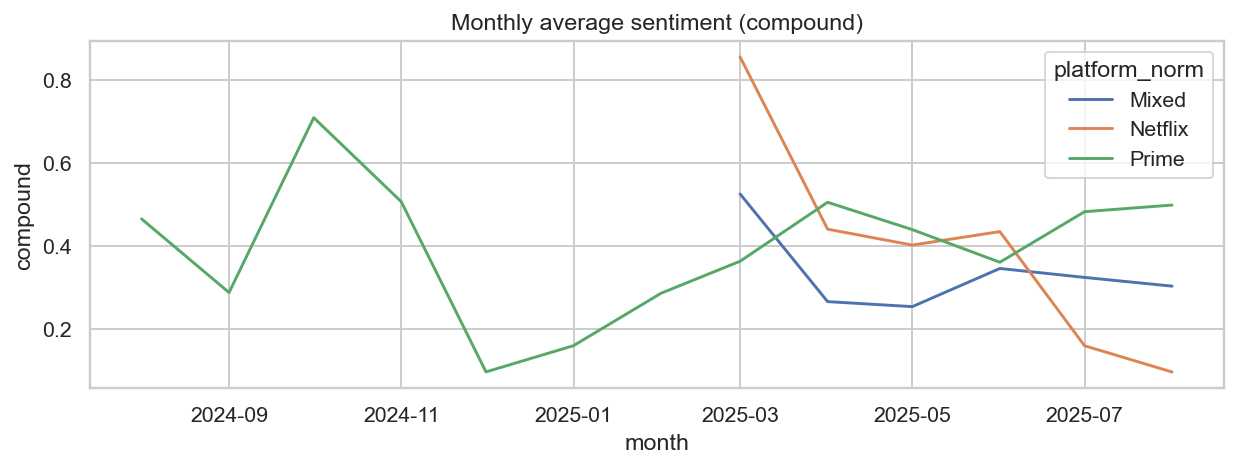

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/07_trend_monthly_sentiment.png


In [13]:
# 7) Monthly average sentiment
monthly_sent = mrk.groupby(["platform_norm","month"])["compound"].mean().reset_index()
plt.figure(figsize=(9,3.5))
sns.lineplot(data=monthly_sent, x="month", y="compound", hue="platform_norm")
plt.title("Monthly average sentiment (compound)")
savefig("07_trend_monthly_sentiment.png")

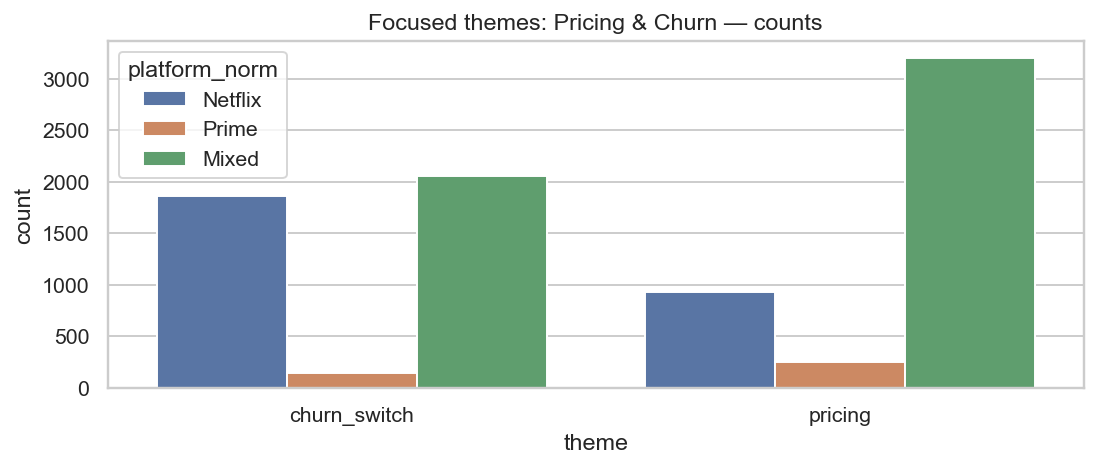

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/08_focus_pricing_churn_counts.png


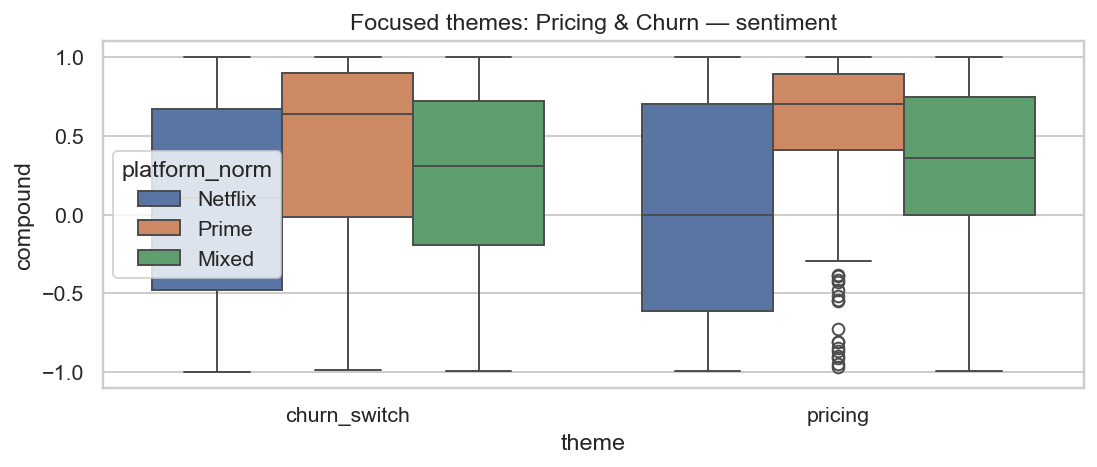

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/09_focus_pricing_churn_sentiment.png


In [14]:

# 8) Focused themes: pricing & churn
focus = mrk[mrk["theme"].isin(["pricing","churn_switch"])].copy()
if not focus.empty:
    plt.figure(figsize=(8,3.5))
    sns.countplot(data=focus, x="theme", hue="platform_norm")
    plt.title("Focused themes: Pricing & Churn — counts")
    savefig("08_focus_pricing_churn_counts.png")

    # Sentiment for focused themes
    plt.figure(figsize=(8,3.5))
    sns.boxplot(data=focus, x="theme", y="compound", hue="platform_norm")
    plt.title("Focused themes: Pricing & Churn — sentiment")
    savefig("09_focus_pricing_churn_sentiment.png")

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:225: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:227: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


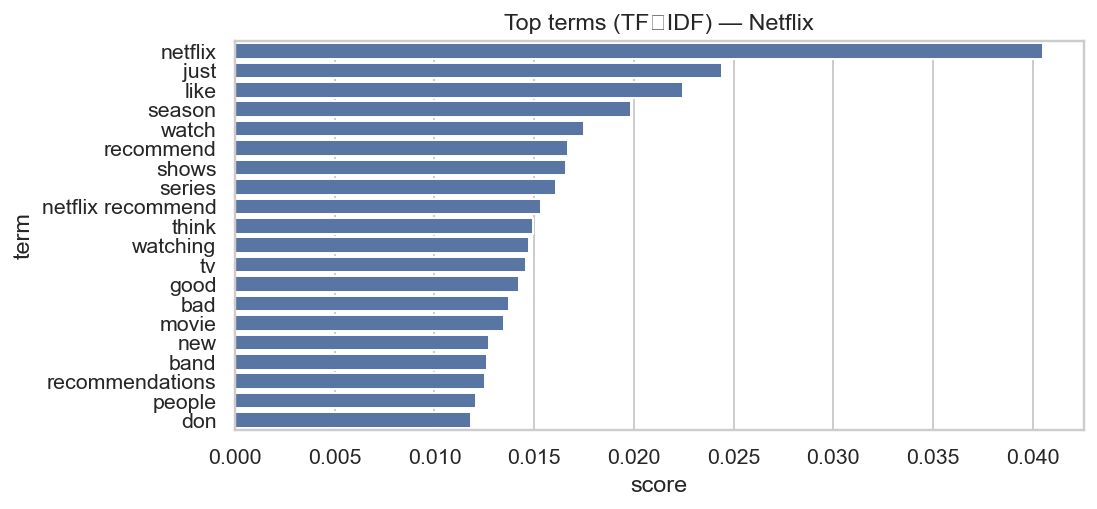

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/10_tfidf_top_terms_netflix.png


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:225: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/2800382594.py:227: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.savefig(path, bbox_inches="tight")
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


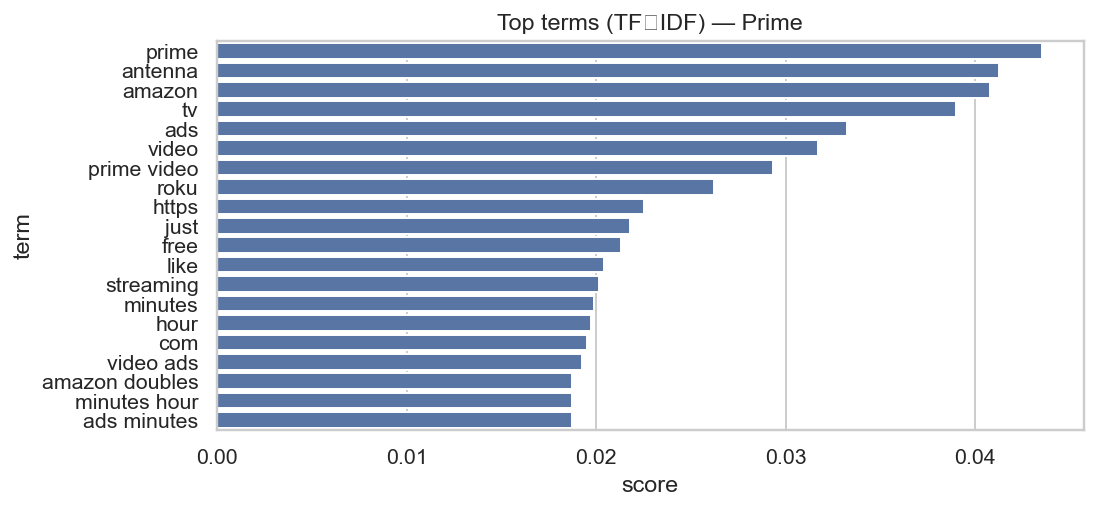

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/10_tfidf_top_terms_prime.png


In [15]:
# 9) TF‑IDF top terms (per platform, marketing‑relevant)
def top_terms(df, label, n=20):
    texts = df["text"].astype(str).tolist()
    if len(texts) < 10:
        print(f"[{label}] not enough texts for TF‑IDF.")
        return
    vec = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        min_df=3,
        stop_words="english"
    )
    X = vec.fit_transform(texts)
    scores = np.asarray(X.mean(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    idx = scores.argsort()[::-1][:n]
    top = pd.DataFrame({"term": terms[idx], "score": scores[idx]})
    plt.figure(figsize=(8,3.8))
    sns.barplot(data=top, x="score", y="term")
    plt.title(f"Top terms (TF‑IDF) — {label}")
    savefig(f"10_tfidf_top_terms_{label.lower()}.png")

for label in ["Netflix","Prime"]:
    top_terms(mrk[mrk["platform_norm"]==label], label, n=20)

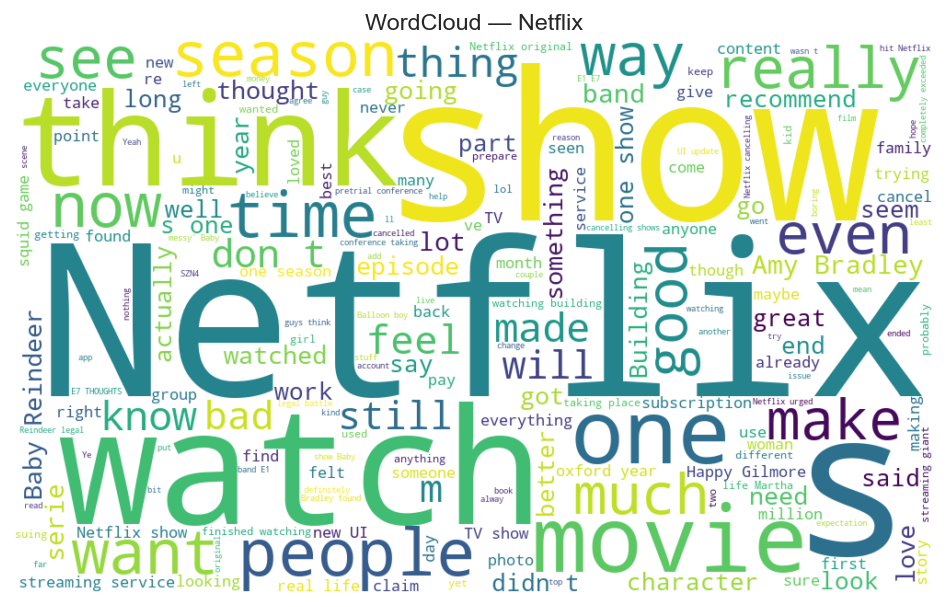

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/11_wordcloud_netflix.png


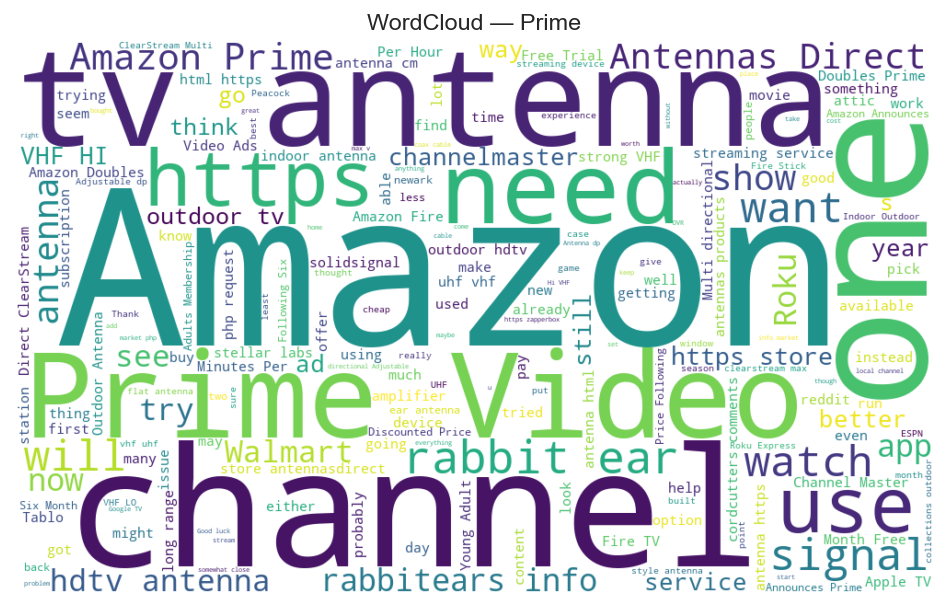

Saved: /Users/saurabkohad/Downloads/reddit_marketing_outputs/11_wordcloud_prime.png


In [16]:
# 10) Wordclouds (if library available)
if WORDCLOUD_OK:
    for label in ["Netflix","Prime"]:
        text = " ".join(mrk[mrk["platform_norm"]==label]["text"].astype(str).tolist())
        if len(text) > 1000:
            wc = WordCloud(width=1000, height=600, background_color="white").generate(text)
            plt.figure(figsize=(8,4.5))
            plt.imshow(wc, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"WordCloud — {label}")
            savefig(f"11_wordcloud_{label.lower()}.png")

In [17]:
# 11) Export summary tables (for dissertation appendices)
# counts by platform & theme
counts_tbl = theme_counts.sort_values(["platform_norm","count"], ascending=[True, False])
counts_tbl.to_csv(os.path.join(OUT_DIR, "summary_counts_by_platform_theme.csv"), index=False)

# average sentiment by platform & theme
sent_tbl = (mrk.groupby(["platform_norm","theme"])[["neg","neu","pos","compound"]]
            .mean().reset_index())
sent_tbl.to_csv(os.path.join(OUT_DIR, "summary_sentiment_by_platform_theme.csv"), index=False)

print("\nAll charts + CSVs saved to:", OUT_DIR)


All charts + CSVs saved to: /Users/saurabkohad/Downloads/reddit_marketing_outputs


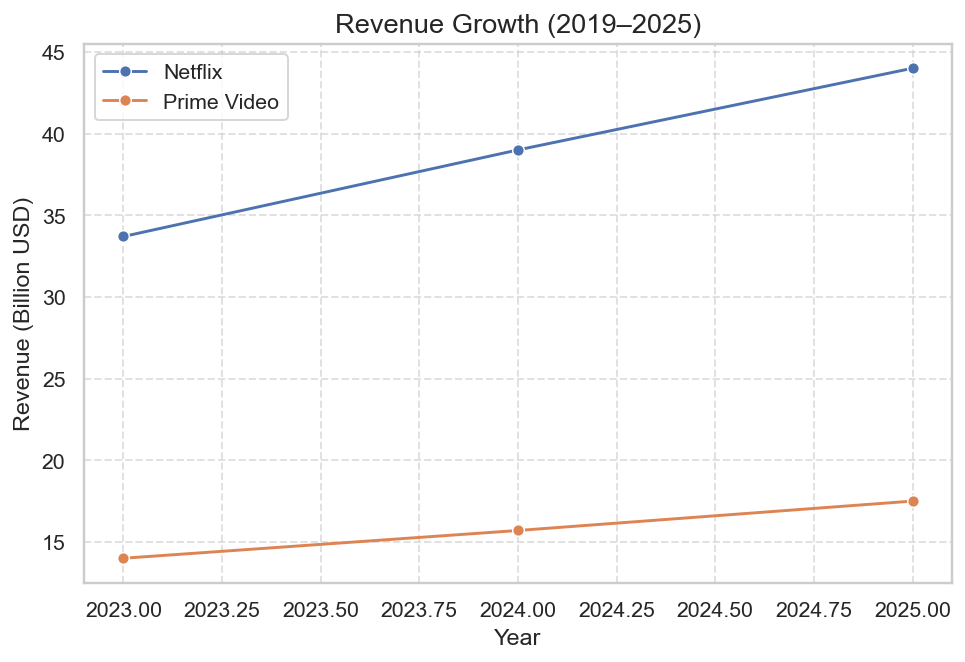

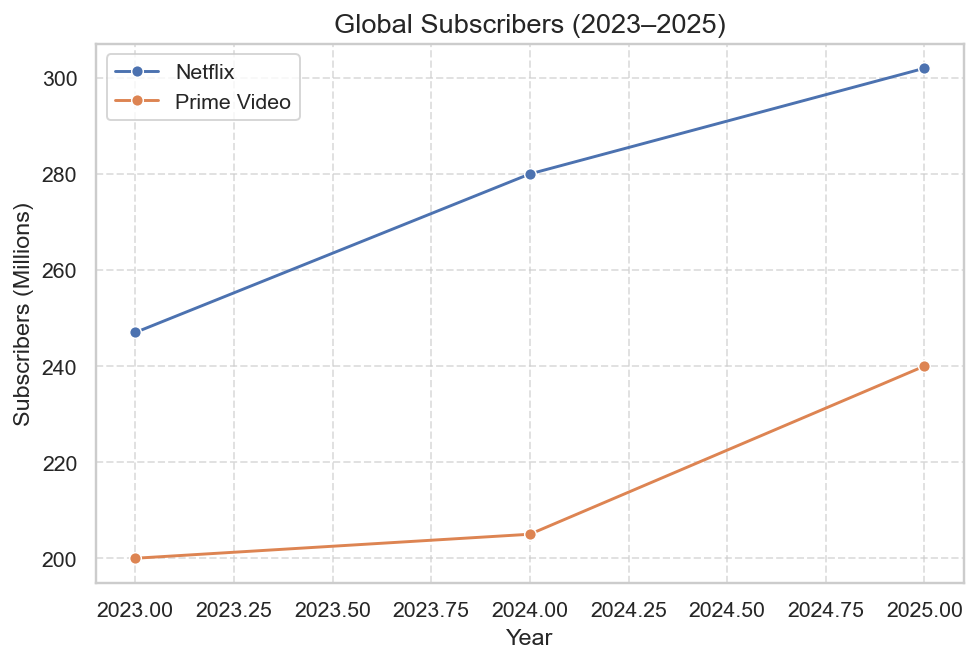

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_30288/902149235.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_strategy, x="Platform", y="Adoption", palette="Set2")


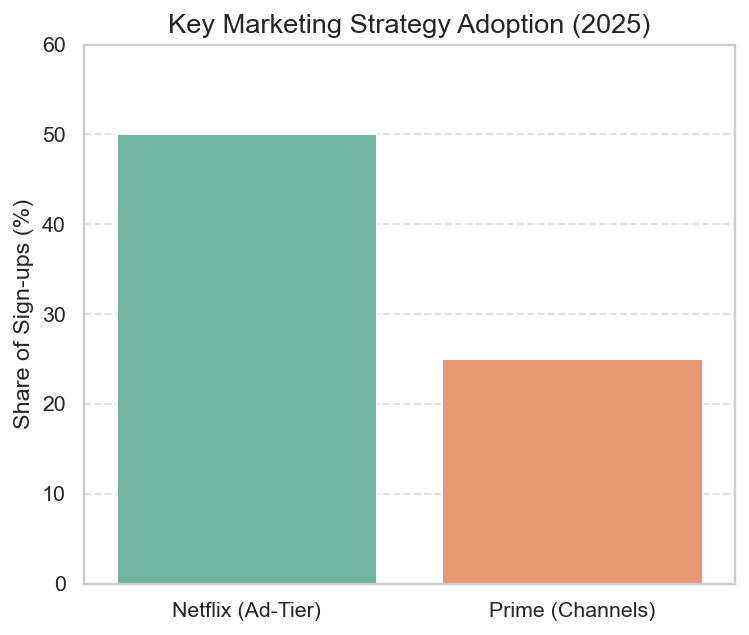

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==== 1. Revenue Growth Data (in billions USD) ====
revenue_data = {
    "Year": [2023, 2024, 2025],
    "Netflix": [33.7, 39.0, 44.0],  # approx values based on growth trends
    "Prime Video": [14.0, 15.7, 17.5]  # est. growth trend
}
df_revenue = pd.DataFrame(revenue_data)

# ==== 2. Subscribers Data (in millions) ====
subscribers_data = {
    "Year": [2023, 2024, 2025],
    "Netflix": [247, 280, 302],  # known data + estimates
    "Prime Video": [200, 205, 240]  # includes bundled Prime subs
}
df_subs = pd.DataFrame(subscribers_data)

# ==== Plot 1: Revenue Growth ====
plt.figure(figsize=(8,5))
sns.lineplot(data=df_revenue, x="Year", y="Netflix", marker="o", label="Netflix")
sns.lineplot(data=df_revenue, x="Year", y="Prime Video", marker="o", label="Prime Video")
plt.title("Revenue Growth (2019–2025)", fontsize=14)
plt.ylabel("Revenue (Billion USD)")
plt.xlabel("Year")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ==== Plot 2: Subscribers ====
plt.figure(figsize=(8,5))
sns.lineplot(data=df_subs, x="Year", y="Netflix", marker="o", label="Netflix")
sns.lineplot(data=df_subs, x="Year", y="Prime Video", marker="o", label="Prime Video")
plt.title("Global Subscribers (2023–2025)", fontsize=14)
plt.ylabel("Subscribers (Millions)")
plt.xlabel("Year")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ==== Plot 3: Marketing Strategy Comparison ====
strategy_data = {
    "Platform": ["Netflix (Ad-Tier)", "Prime (Channels)"],
    "Adoption": [50, 25]  # % new signups attributed
}
df_strategy = pd.DataFrame(strategy_data)

plt.figure(figsize=(6,5))
sns.barplot(data=df_strategy, x="Platform", y="Adoption", palette="Set2")
plt.title("Key Marketing Strategy Adoption (2025)", fontsize=14)
plt.ylabel("Share of Sign-ups (%)")
plt.xlabel("")
plt.ylim(0, 60)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


Ratings shape: (25000095, 4)
Movies shape: (62423, 3)
Tags shape: (1093360, 4)

=== Ratings Head ===
   userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

=== Movies Head ===
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Unique users: 162541
Unique movies: 59047
Total 

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_1351/3765055110.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


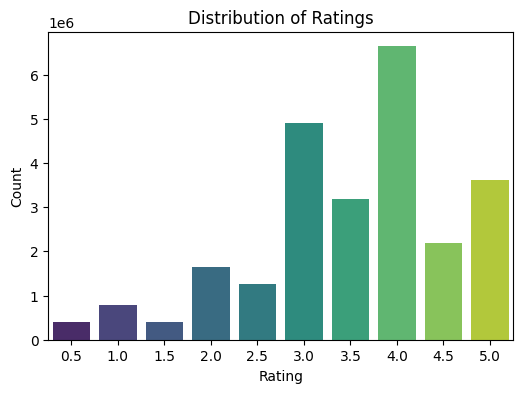

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_1351/3765055110.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="title", x="rating_count", data=top_movies, palette="mako")


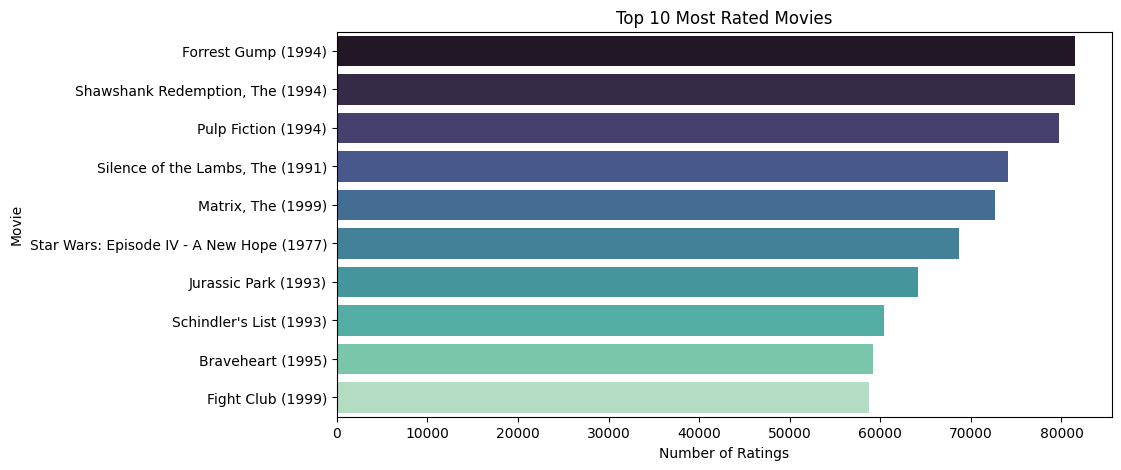

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Path to your unzipped MovieLens folder
path = "/Users/saurabkohad/Downloads/ml-25m"

# Load key files
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))
movies = pd.read_csv(os.path.join(path, "movies.csv"))
tags = pd.read_csv(os.path.join(path, "tags.csv"))

# --- Quick Checks ---
print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)
print("Tags shape:", tags.shape)

print("\n=== Ratings Head ===")
print(ratings.head())

print("\n=== Movies Head ===")
print(movies.head())

# --- Basic Summary ---
print("\nUnique users:", ratings['userId'].nunique())
print("Unique movies:", ratings['movieId'].nunique())
print("Total ratings:", len(ratings))

# --- Ratings Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# --- Top 10 Movies by Rating Count ---
top_movies = ratings['movieId'].value_counts().head(10).reset_index()
top_movies.columns = ['movieId','rating_count']
top_movies = top_movies.merge(movies, on='movieId')

plt.figure(figsize=(10,5))
sns.barplot(y="title", x="rating_count", data=top_movies, palette="mako")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie")
plt.show()



=== Ratings with datetime ===
   userId  movieId  rating   timestamp            datetime  year    month
0       1      296     5.0  1147880044 2006-05-17 15:34:04  2006  2006-05
1       1      306     3.5  1147868817 2006-05-17 12:26:57  2006  2006-05
2       1      307     5.0  1147868828 2006-05-17 12:27:08  2006  2006-05
3       1      665     5.0  1147878820 2006-05-17 15:13:40  2006  2006-05
4       1      899     3.5  1147868510 2006-05-17 12:21:50  2006  2006-05


/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_2943/3798149178.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


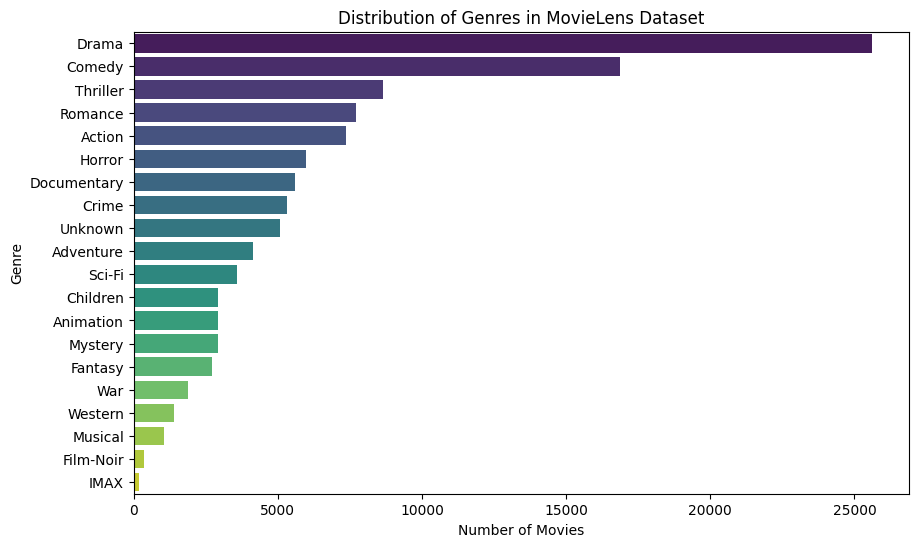


=== Genre one-hot encoded (sample) ===
         Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
movieId                                                                       
1             0          1          1         1       1      0            0   
2             0          1          0         1       0      0            0   
3             0          0          0         0       1      0            0   
4             0          0          0         0       1      0            0   
5             0          0          0         0       1      0            0   

         Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  \
movieId                                                                       
1            0        1          0       0     0        0        0        0   
2            0        1          0       0     0        0        0        0   
3            0        0          0       0     0        0        0        1   
4          

/var/folders/x9/bnr6h6nd0b169t595mf45gch0000gn/T/ipykernel_2943/3798149178.py:50: PerformanceWarning: The following operation may generate 9597558427 cells in the resulting pandas object.
  user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')



User–Item Matrix shape: (162541, 59047)
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2           3.5     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           3.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  209145  209147  209151  209153  209155  209157  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     

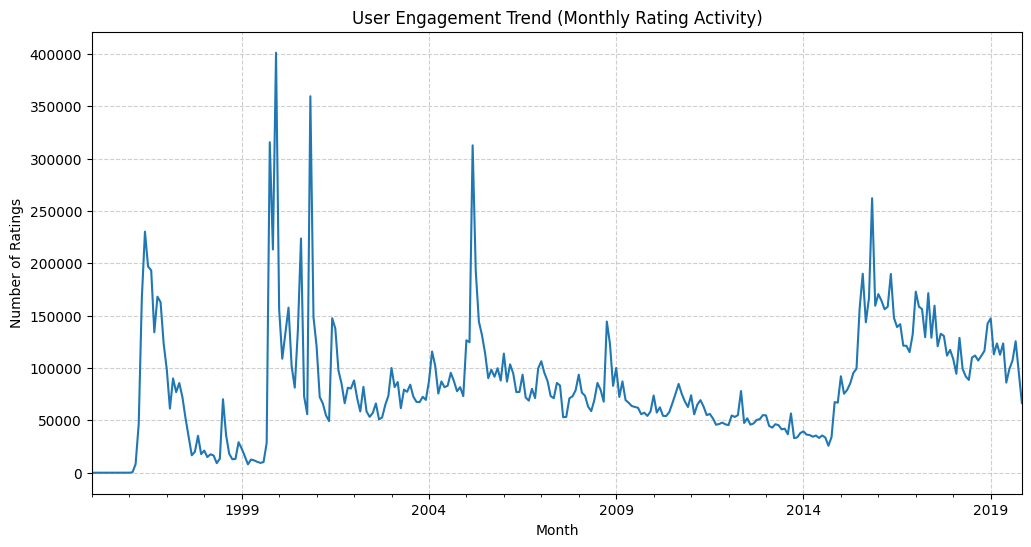

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MultiLabelBinarizer

# Path to your dataset
path = "/Users/saurabkohad/Downloads/ml-25m"

# Load datasets
ratings = pd.read_csv(os.path.join(path, "ratings.csv"))
movies = pd.read_csv(os.path.join(path, "movies.csv"))

# --- 1. Convert timestamp → datetime ---
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year
ratings['month'] = ratings['datetime'].dt.to_period('M')

print("\n=== Ratings with datetime ===")
print(ratings.head())

# --- 2. Genre processing ---
movies['genres'] = movies['genres'].replace('(no genres listed)', 'Unknown')
movies['genre_list'] = movies['genres'].apply(lambda x: x.split('|'))

# Flatten genre list for visualization
all_genres = [g for sublist in movies['genre_list'] for g in sublist]
genre_counts = pd.Series(all_genres).value_counts()

# --- Plot 1: Genre distribution ---
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Distribution of Genres in MovieLens Dataset")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

# --- 3. One-hot encode genres ---
mlb = MultiLabelBinarizer()
genre_dummies = pd.DataFrame(
    mlb.fit_transform(movies['genre_list']),
    columns=mlb.classes_,
    index=movies['movieId']
)

print("\n=== Genre one-hot encoded (sample) ===")
print(genre_dummies.head())

# --- 4. User–Item Rating Matrix ---
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
print("\nUser–Item Matrix shape:", user_item_matrix.shape)
print(user_item_matrix.head(5))

# --- 5. Plot Rating Activity Over Time (Monthly) ---
monthly_activity = ratings.groupby('month').size()

plt.figure(figsize=(12,6))
monthly_activity.plot()
plt.title("User Engagement Trend (Monthly Rating Activity)")
plt.xlabel("Month")
plt.ylabel("Number of Ratings")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



In [5]:
# ===================== MovieLens 25M — User–User CF (Step 3A, Robust v2) =====================
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# ---------- Paths ----------
ML_PATH = "/Users/saurabkohad/Downloads/ml-25m"  # <- your path
RATINGS_CSV = os.path.join(ML_PATH, "ratings.csv")
MOVIES_CSV  = os.path.join(ML_PATH, "movies.csv")

# ---------- Load ----------
ratings = pd.read_csv(RATINGS_CSV)
movies  = pd.read_csv(MOVIES_CSV)

# ---------- Subset to keep it fast & reproducible ----------
min_ratings_per_user = 50
users_keep = ratings.groupby("userId").size().loc[lambda s: s >= min_ratings_per_user].index
ratings_filt = ratings[ratings.userId.isin(users_keep)]

# Optional: downsample users if needed (e.g., 15k users)
target_users = 15000
if ratings_filt["userId"].nunique() > target_users:
    sampled_users = pd.Series(users_keep).sample(target_users, random_state=42).values
    ratings_filt = ratings_filt[ratings_filt.userId.isin(sampled_users)]

print("Users:", ratings_filt.userId.nunique(),
      "| Movies:", ratings_filt.movieId.nunique(),
      "| Ratings:", len(ratings_filt))

# ---------- Time-aware train/test split (last rating of each user -> test) ----------
ratings_filt = ratings_filt.sort_values(["userId", "timestamp"])
last_idx = ratings_filt.groupby("userId").tail(1).index  # one held-out interaction per user
test = ratings_filt.loc[last_idx]
train = ratings_filt.drop(index=last_idx)

print("Train size:", len(train), "| Test size:", len(test))

# ---------- Build user-item matrix on TRAIN ----------
user_ids = np.sort(train.userId.unique())
movie_ids = np.sort(train.movieId.unique())

user_to_idx  = {int(u): int(i) for i, u in enumerate(user_ids)}
movie_to_idx = {int(m): int(i) for i, m in enumerate(movie_ids)}
idx_to_user  = {i: u for u, i in user_to_idx.items()}

rows = train.userId.map(user_to_idx).astype(np.int64).values
cols = train.movieId.map(movie_to_idx).astype(np.int64).values
data = train.rating.values.astype(np.float32)

R = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print("User–Item matrix shape:", R.shape)

# ---------- Mean-center per user ----------
def user_means_from_sparse(R):
    sums = np.array(R.sum(axis=1)).ravel()
    counts = np.diff(R.indptr)
    means = np.divide(sums, counts, out=np.zeros_like(sums, dtype=float), where=counts!=0)
    return means

user_means = user_means_from_sparse(R)

R_centered = R.copy().astype(np.float32)
for u in range(R_centered.shape[0]):
    start, end = R_centered.indptr[u], R_centered.indptr[u+1]
    if start != end:
        R_centered.data[start:end] -= user_means[u]

# ---------- Compute user-user cosine similarity (on centered ratings) ----------
# NOTE: dense_output=False gives a sparse matrix — we handle slices carefully below.
sim_users = cosine_similarity(R_centered, dense_output=False)
print("Similarity matrix computed.")

# ---------- Precompute CSC once for efficient column access ----------
R_csc = R.tocsc()
R_centered_csc = R_centered.tocsc()

def _to_1d_array(x):
    """Ensure we have a dense 1‑D numpy array."""
    if issparse(x):
        return x.toarray().ravel()
    x = np.asarray(x)
    return x.ravel()

def predict_user_item(u_idx, i_idx, K=40, min_sim=0.0):
    """Predict rating for user-index u_idx on item-index i_idx using top-K similar neighbours."""
    # force plain Python ints
    try:
        u_idx = int(u_idx); i_idx = int(i_idx)
    except Exception:
        return np.nan

    # bounds guard
    if not (0 <= u_idx < R.shape[0]) or not (0 <= i_idx < R.shape[1]):
        return np.nan

    # users who rated item i (column slice in CSC)
    start, end = R_csc.indptr[i_idx], R_csc.indptr[i_idx+1]
    raters = R_csc.indices[start:end]  # user indices who rated i
    if len(raters) == 0:
        return float(user_means[u_idx])  # fallback to user mean

    # similarities between target user and raters  -> force dense 1D
    sims = sim_users[u_idx, raters]
    sims = _to_1d_array(sims)

    # threshold + top-K by absolute similarity
    if sims.size == 0:
        return float(user_means[u_idx])
    mask = sims > float(min_sim)
    raters = raters[mask]
    sims   = sims[mask]
    if sims.size == 0:
        return float(user_means[u_idx])

    # top-K neighbours
    topk = np.argsort(-np.abs(sims))[:K]
    nbrs = raters[topk]
    nbr_sims = sims[topk]

    # neighbour centered ratings for this item
    cstart, cend = R_centered_csc.indptr[i_idx], R_centered_csc.indptr[i_idx+1]
    raters_c = R_centered_csc.indices[cstart:cend]
    vals_c   = R_centered_csc.data[cstart:cend]
    if len(raters_c) == 0:
        return float(user_means[u_idx])

    # map neighbour -> centered rating
    val_map = {int(u): float(v) for u, v in zip(raters_c, vals_c)}
    nbr_vals = np.array([val_map.get(int(n), np.nan) for n in nbrs], dtype=np.float32)
    keep = ~np.isnan(nbr_vals)
    if keep.sum() == 0:
        return float(user_means[u_idx])

    nbr_vals = nbr_vals[keep]
    nbr_sims = nbr_sims[keep]

    denom = np.sum(np.abs(nbr_sims))
    if denom == 0:
        return float(user_means[u_idx])

    pred_centered = np.sum(nbr_sims * nbr_vals) / denom
    return float(user_means[u_idx] + pred_centered)

# ---------- Evaluate RMSE on TEST (only items seen in TRAIN) ----------
test_eval = test[test.movieId.isin(movie_ids)].copy()
if test_eval.empty:
    print("No test items are in the training set after subsetting. Increase sample size or relax filtering.")
else:
    # map to indices; drop missing; cast to int64
    test_eval["u_idx"] = test_eval.userId.map(user_to_idx)
    test_eval["i_idx"] = test_eval.movieId.map(movie_to_idx)
    test_eval = test_eval.dropna(subset=["u_idx","i_idx"]).copy()
    test_eval["u_idx"] = test_eval["u_idx"].astype(np.int64)
    test_eval["i_idx"] = test_eval["i_idx"].astype(np.int64)

    # Optional: sample test for speed
    # if len(test_eval) > 5000:
    #     test_eval = test_eval.sample(5000, random_state=42)

    preds = []
    for _, row in test_eval.iterrows():
        preds.append(predict_user_item(int(row.u_idx), int(row.i_idx), K=40, min_sim=0.0))

    preds = np.array(preds, dtype=float)
    mask = ~np.isnan(preds)
    rmse = sqrt(mean_squared_error(test_eval.loc[mask, "rating"].values, preds[mask]))
    print(f"User–User CF RMSE (1‑held‑out per user): {rmse:.4f}")

# ---------- Recommend Top‑N for a given user ----------
def recommend_for_user(target_user_id, N=10, K=40, min_sim=0.0, sample_candidates=5000):
    """Return top‑N recommendations for a training user."""
    if int(target_user_id) not in user_to_idx:
        raise ValueError("User not in training subset. Pick a user from 'user_ids'.")
    u_idx = int(user_to_idx[int(target_user_id)])

    # candidate items = movies in train the user hasn't rated
    user_row = R.getrow(u_idx)
    rated_items = set(user_row.indices.tolist())
    candidates = np.setdiff1d(np.arange(R.shape[1], dtype=np.int64),
                              np.fromiter(rated_items, dtype=np.int64, count=len(rated_items)))

    # optional sampling for speed
    if sample_candidates and len(candidates) > sample_candidates:
        candidates = np.random.choice(candidates, size=sample_candidates, replace=False)

    scores = []
    for i_idx in candidates:
        pred = predict_user_item(u_idx, int(i_idx), K=K, min_sim=min_sim)
        scores.append((int(i_idx), float(pred)))
    if not scores:
        return pd.DataFrame(columns=["movieId","title","pred_rating"])

    scores = sorted(scores, key=lambda x: x[1], reverse=True)[:N]
    out = pd.DataFrame(scores, columns=["i_idx","pred_rating"])
    inv_movie_map = {v:k for k,v in movie_to_idx.items()}
    out["movieId"] = out["i_idx"].map(inv_movie_map).astype(int)
    out = out.merge(movies, on="movieId", how="left")[["movieId","title","pred_rating"]]
    return out

# ---------- Example usage ----------
example_user = int(np.random.choice(user_ids, 1)[0])
print("\nExample user:", example_user)
recs = recommend_for_user(example_user, N=10, K=40)
print("\nTop‑N recommendations:")
print(recs)



Users: 15000 | Movies: 34368 | Ratings: 3411774
Train size: 3396774 | Test size: 15000
User–Item matrix shape: (15000, 34319)
Similarity matrix computed.
User–User CF RMSE (1‑held‑out per user): 0.8970

Example user: 147485

Top‑N recommendations:
   movieId                                              title  pred_rating
0   138580                               I Can See You (2008)     6.323297
1   203170  Secrets in the Sky: The Untold Story of Skunk ...     5.975551
2   138172                                    Baseline (2010)     5.827577
3   200930                          C'est quoi la vie? (1999)     5.597088
4     7356                              Night Crossing (1981)     5.566342
5   132333                                        Seve (2014)     5.516608
6   171297                   Doug Stanhope: No Refunds (2007)     5.416168
7   187847                  Neat: The Story of Bourbon (2018)     5.416168
8   196695             All the Creatures Were Stirring (2018)     5.416168
9 

Users: 15000 | Movies: 34368 | Ratings: 3411774
Train size: 3396774 | Test size: 15000
User–Item matrix shape: (15000, 34319)


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


SVD explained variance ratio sum (k=80, n_iter=10): 0.231
TruncatedSVD RMSE (1‑held‑out per user): 0.9535

Example user: 160219
Top‑N (SVD):
   movieId                                   title       est
0      745  Wallace & Gromit: A Close Shave (1995)  4.332014
1     1729                     Jackie Brown (1997)  4.323750
2     5679                        Ring, The (2002)  4.219610
3     1231                 Right Stuff, The (1983)  4.196985
4     1409                          Michael (1996)  4.193154
5     2761                  Iron Giant, The (1999)  4.188432
6    30707              Million Dollar Baby (2004)  4.184416
7     2321                    Pleasantville (1998)  4.180809
8     4368                   Dr. Dolittle 2 (2001)  4.176894
9   115569                     Nightcrawler (2014)  4.174235

Catalog Coverage (Top‑10 over 1000 users): 5.71%
Genre Diversity — mean entropy across users: 3.303 bits


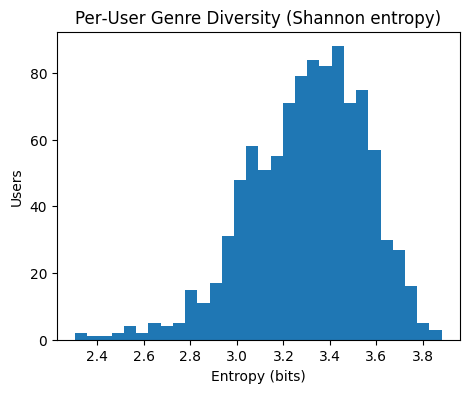

Novelty — mean long‑tail share in Top‑10: 0.07%


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 40, n_iter= 7 -> RMSE=0.9544, EVR=0.169, time=0.8s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 40, n_iter=10 -> RMSE=0.9544, EVR=0.170, time=1.2s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 40, n_iter=15 -> RMSE=0.9544, EVR=0.170, time=1.5s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 60, n_iter= 7 -> RMSE=0.9539, EVR=0.202, time=1.2s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 60, n_iter=10 -> RMSE=0.9539, EVR=0.203, time=1.6s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 60, n_iter=15 -> RMSE=0.9541, EVR=0.203, time=2.1s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 80, n_iter= 7 -> RMSE=0.9537, EVR=0.230, time=1.5s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 80, n_iter=10 -> RMSE=0.9535, EVR=0.231, time=2.0s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k= 80, n_iter=15 -> RMSE=0.9537, EVR=0.231, time=3.0s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=100, n_iter= 7 -> RMSE=0.9543, EVR=0.255, time=1.8s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=100, n_iter=10 -> RMSE=0.9542, EVR=0.256, time=2.4s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=100, n_iter=15 -> RMSE=0.9541, EVR=0.256, time=3.5s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=120, n_iter= 7 -> RMSE=0.9537, EVR=0.278, time=1.9s


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


k=120, n_iter=10 -> RMSE=0.9538, EVR=0.279, time=2.7s
k=120, n_iter=15 -> RMSE=0.9537, EVR=0.279, time=3.5s

SVD hyperparameter results (sorted):
      k  n_iter      RMSE   ExplVar  TrainTimeSec
7    80      10  0.953548  0.230746      1.950312
12  120       7  0.953674  0.278441      1.945940
8    80      15  0.953683  0.231015      2.979607
6    80       7  0.953704  0.230155      1.466857
14  120      15  0.953734  0.279495      3.545807
13  120      10  0.953800  0.279152      2.745659
3    60       7  0.953920  0.202034      1.173817
4    60      10  0.953933  0.202507      1.641599
5    60      15  0.954055  0.202729      2.147697
11  100      15  0.954130  0.256400      3.537054


/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/saurabkohad/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


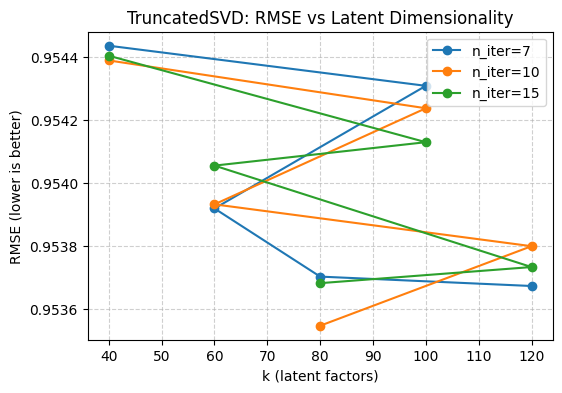

In [7]:
# ================= MovieLens 25M — Matrix Factorization via TruncatedSVD (Full) =================
# - Time-aware split (last rating per user -> test)
# - Mean-centered user–item CSR on TRAIN
# - TruncatedSVD latent factors (users/items)
# - Predict, evaluate RMSE, Top‑N recommendations
# - Diversity metrics: catalog coverage, per-user genre entropy, novelty (long-tail share)
# - Hyperparameter sweep for k and n_iter
# ===============================================================================================

import os, time, numpy as np, pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from collections import Counter

# ---------- Paths ----------
ML_PATH = "/Users/saurabkohad/Downloads/ml-25m"   # <- your path
RATINGS_CSV = os.path.join(ML_PATH, "ratings.csv")
MOVIES_CSV  = os.path.join(ML_PATH, "movies.csv")

# ---------- Load ----------
ratings = pd.read_csv(RATINGS_CSV)
movies  = pd.read_csv(MOVIES_CSV)

# ---------- Filter active users & (optional) downsample ----------
min_ratings_per_user = 50
users_keep = ratings.groupby("userId").size().loc[lambda s: s >= min_ratings_per_user].index
ratings_filt = ratings[ratings.userId.isin(users_keep)].copy()

target_users = 15000  # adjust for RAM/time (e.g., 8000 on low RAM)
if ratings_filt["userId"].nunique() > target_users:
    sampled_users = pd.Series(users_keep).sample(target_users, random_state=42).values
    ratings_filt = ratings_filt[ratings_filt.userId.isin(sampled_users)].copy()

print("Users:", ratings_filt.userId.nunique(),
      "| Movies:", ratings_filt.movieId.nunique(),
      "| Ratings:", len(ratings_filt))

# ---------- Time-aware split (last interaction per user -> test) ----------
ratings_filt.sort_values(["userId","timestamp"], inplace=True)
test_idx = ratings_filt.groupby("userId").tail(1).index
test_df  = ratings_filt.loc[test_idx].copy()
train_df = ratings_filt.drop(index=test_idx).copy()
print("Train size:", len(train_df), "| Test size:", len(test_df))

# ---------- Build TRAIN user–item matrix ----------
user_ids = np.sort(train_df.userId.unique())
movie_ids = np.sort(train_df.movieId.unique())
user_to_idx  = {int(u): int(i) for i, u in enumerate(user_ids)}
movie_to_idx = {int(m): int(i) for i, m in enumerate(movie_ids)}

rows = train_df.userId.map(user_to_idx).astype(np.int64).values
cols = train_df.movieId.map(movie_to_idx).astype(np.int64).values
data = train_df.rating.values.astype(np.float32)
R = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(movie_ids)))
print("User–Item matrix shape:", R.shape)

# ---------- Mean-center per user ----------
def center_by_user(R):
    sums   = np.array(R.sum(axis=1)).ravel()
    counts = np.diff(R.indptr)
    means  = np.divide(sums, counts, out=np.zeros_like(sums, dtype=float), where=counts!=0)
    Rc = R.copy().astype(np.float32)
    for u in range(Rc.shape[0]):
        s, e = Rc.indptr[u], Rc.indptr[u+1]
        if s != e:
            Rc.data[s:e] -= means[u]
    return Rc, means

R_centered, user_means = center_by_user(R)

# ---------- TruncatedSVD model (choose k & n_iter here) ----------
k = 80
n_iter = 10
svd = TruncatedSVD(n_components=k, n_iter=n_iter, random_state=42)
Uk = svd.fit_transform(R_centered)           # (n_users, k)
Vk = svd.components_.T.astype(np.float32)    # (n_items, k)
evr = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance ratio sum (k={k}, n_iter={n_iter}): {evr:.3f}")

# ---------- Predictor ----------
def predict(u_idx: int, i_idx: int) -> float:
    if not (0 <= u_idx < Uk.shape[0]) or not (0 <= i_idx < Vk.shape[0]):
        return np.nan
    return float(np.dot(Uk[u_idx], Vk[i_idx]) + user_means[u_idx])

# ---------- Evaluate RMSE on TEST (only items seen in TRAIN) ----------
eval_df = test_df[test_df.userId.isin(user_to_idx) & test_df.movieId.isin(movie_to_idx)].copy()
eval_df["u_idx"] = eval_df.userId.map(user_to_idx).astype(np.int64)
eval_df["i_idx"] = eval_df.movieId.map(movie_to_idx).astype(np.int64)

# Optional: sample for speed
# if len(eval_df) > 10000:
#     eval_df = eval_df.sample(10000, random_state=42)

preds = np.array([predict(int(u), int(i)) for u, i in zip(eval_df.u_idx, eval_df.i_idx)], dtype=float)
mask  = ~np.isnan(preds)
rmse  = sqrt(mean_squared_error(eval_df.loc[mask, "rating"].values, preds[mask]))
print(f"TruncatedSVD RMSE (1‑held‑out per user): {rmse:.4f}")

# ---------- Top‑N recommendations ----------
user_items_train = train_df.groupby("userId")["movieId"].apply(set).to_dict()
all_items = np.array(list(movie_ids), dtype=np.int64)

def recommend_for_user_svd(user_id: int, N=10, candidate_sample=2000):
    if user_id not in user_items_train:
        raise ValueError("User not in training subset.")
    u_idx = user_to_idx[int(user_id)]
    rated = user_items_train[user_id]
    candidates = np.setdiff1d(all_items, np.fromiter(rated, dtype=np.int64, count=len(rated)))
    if len(candidates) == 0:
        return pd.DataFrame(columns=["movieId","title","est"])
    if len(candidates) > candidate_sample:
        candidates = np.random.choice(candidates, size=candidate_sample, replace=False)

    i_idx_arr = np.array([movie_to_idx[int(i)] for i in candidates], dtype=np.int64)
    scores = Uk[u_idx].dot(Vk[i_idx_arr].T) + user_means[u_idx]
    top_idx = np.argsort(-scores)[:N]
    top_items = candidates[top_idx]
    top_scores = scores[top_idx]

    out = pd.DataFrame({"movieId": top_items.astype(int), "est": top_scores.astype(float)})
    out = out.merge(movies, on="movieId", how="left")[["movieId","title","est"]]
    return out

example_user = int(np.random.choice(list(user_items_train.keys()), 1)[0])
print("\nExample user:", example_user)
print("Top‑N (SVD):")
print(recommend_for_user_svd(example_user, N=10))

# ---------- Diversity metrics ----------
# 1) Catalog coverage over a user sample
def topn_for_users(user_list, N=10):
    seen = set(); rows = []
    for uid in user_list:
        try:
            recs = recommend_for_user_svd(int(uid), N=N)
            for _, r in recs.iterrows():
                seen.add(int(r.movieId))
                rows.append((int(uid), int(r.movieId), float(r.est)))
        except Exception:
            continue
    return seen, pd.DataFrame(rows, columns=["userId","movieId","est"])

sample_users = np.random.choice(list(user_items_train.keys()), size=min(1000, len(user_items_train)), replace=False)
covered, rec_matrix = topn_for_users(sample_users, N=10)
catalog_coverage = 100.0 * len(covered) / len(movie_ids)
print(f"\nCatalog Coverage (Top‑10 over {len(sample_users)} users): {catalog_coverage:.2f}%")

# 2) Genre diversity (Shannon entropy per user’s Top‑N)
movies_proc = movies.copy()
movies_proc["genres"] = movies_proc["genres"].replace("(no genres listed)", "Unknown")
movies_proc["genre_list"] = movies_proc["genres"].apply(lambda s: str(s).split("|"))
rec_matrix = rec_matrix.merge(movies_proc[["movieId","genre_list"]], on="movieId", how="left")

def shannon_entropy(counts: Counter) -> float:
    total = sum(counts.values())
    if total == 0: return 0.0
    ent = 0.0
    for c in counts.values():
        p = c/total
        ent += -p * np.log2(p + 1e-12)
    return ent

user_entropy = []
for uid, group in rec_matrix.groupby("userId"):
    genres = [g for lst in group["genre_list"].dropna().tolist() for g in lst]
    counts = Counter(genres)
    user_entropy.append(shannon_entropy(counts))
user_entropy = np.array(user_entropy, dtype=float)
print(f"Genre Diversity — mean entropy across users: {np.nanmean(user_entropy):.3f} bits")

plt.figure(figsize=(5.2,4))
plt.hist(user_entropy[~np.isnan(user_entropy)], bins=30)
plt.title("Per‑User Genre Diversity (Shannon entropy)")
plt.xlabel("Entropy (bits)"); plt.ylabel("Users")
plt.show()

# 3) Novelty (long‑tail share in Top‑N)
# Define "long‑tail" as items below a popularity percentile (e.g., bottom 60% by rating count in TRAIN)
item_pop = train_df.groupby("movieId").size().rename("count").reset_index()
item_pop["rank"] = item_pop["count"].rank(method="first", ascending=False)
pct = 0.60  # bottom 60% = long tail
threshold_rank = item_pop["rank"].quantile(1 - pct)
longtail_items = set(item_pop.loc[item_pop["rank"] > threshold_rank, "movieId"].astype(int).tolist())

def novelty_share(rec_df):
    if rec_df.empty: return np.nan
    return np.mean(rec_df["movieId"].astype(int).isin(longtail_items))

novelty_scores = []
for uid in sample_users:
    try:
        recs = recommend_for_user_svd(int(uid), N=10)
        novelty_scores.append(novelty_share(recs))
    except:
        novelty_scores.append(np.nan)
novelty_scores = np.array(novelty_scores, dtype=float)
print(f"Novelty — mean long‑tail share in Top‑10: {np.nanmean(novelty_scores)*100:.2f}%")

# ---------- Hyperparameter sweep (k × n_iter) ----------
def build_R_from_train(train_df, user_to_idx, movie_to_idx):
    rows = train_df.userId.map(user_to_idx).astype(np.int64).values
    cols = train_df.movieId.map(movie_to_idx).astype(np.int64).values
    data = train_df.rating.values.astype(np.float32)
    return csr_matrix((data, (rows, cols)), shape=(len(user_to_idx), len(movie_to_idx)))

def eval_svd_config(R_centered, user_means, eval_df, k, n_iter):
    t0 = time.time()
    svd = TruncatedSVD(n_components=k, n_iter=n_iter, random_state=42)
    Uk = svd.fit_transform(R_centered)
    Vk = svd.components_.T.astype(np.float32)
    evr = float(svd.explained_variance_ratio_.sum())

    u_idx = eval_df["u_idx"].values
    i_idx = eval_df["i_idx"].values
    preds = np.sum(Uk[u_idx] * Vk[i_idx], axis=1) + user_means[u_idx]
    rmse = sqrt(mean_squared_error(eval_df["rating"].values, preds))
    secs = time.time() - t0
    return rmse, evr, secs

# rebuild matrices for sweep to be explicit (reuse what we have)
R = build_R_from_train(train_df, user_to_idx, movie_to_idx)
R_centered, user_means = center_by_user(R)
eval_df = test_df[test_df.userId.isin(user_to_idx) & test_df.movieId.isin(movie_to_idx)].copy()
eval_df["u_idx"] = eval_df.userId.map(user_to_idx).astype(np.int64)
eval_df["i_idx"] = eval_df.movieId.map(movie_to_idx).astype(np.int64)

grid = []
for k_try in [40, 60, 80, 100, 120]:
    for it_try in [7, 10, 15]:
        rmse_try, evr_try, secs_try = eval_svd_config(R_centered, user_means, eval_df, k_try, it_try)
        grid.append({"k": k_try, "n_iter": it_try, "RMSE": rmse_try, "ExplVar": evr_try, "TrainTimeSec": secs_try})
        print(f"k={k_try:3d}, n_iter={it_try:2d} -> RMSE={rmse_try:.4f}, EVR={evr_try:.3f}, time={secs_try:.1f}s")

svd_grid = pd.DataFrame(grid).sort_values(["RMSE","TrainTimeSec"], ascending=[True, True])
print("\nSVD hyperparameter results (sorted):")
print(svd_grid.head(10))

# Visual: RMSE vs k per n_iter
plt.figure(figsize=(6,4))
for it in sorted(svd_grid.n_iter.unique()):
    sub = svd_grid[svd_grid.n_iter == it]
    plt.plot(sub.k, sub.RMSE, marker="o", label=f"n_iter={it}")
plt.title("TruncatedSVD: RMSE vs Latent Dimensionality")
plt.xlabel("k (latent factors)")
plt.ylabel("RMSE (lower is better)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
